Here we first import package

In [2]:
#import packages
import pandas as pd
import streamlit as st


In [8]:
#read mtngh file in data folder with pandas
df1 = pd.read_csv("data/MTNGH.csv")
#df2 = df1.reset_index()['Closing Price']
#reversed index so index O would correspond to price value for 01/02/2019
#and final index would correspond to price value for 01/02/2023

df2=df1["Closing Price VWAP (GHS)"]
df2=df2[::-1].reset_index(drop = True)
df2.info()

<class 'pandas.core.series.Series'>
RangeIndex: 983 entries, 0 to 982
Series name: Closing Price VWAP (GHS)
Non-Null Count  Dtype  
--------------  -----  
983 non-null    float64
dtypes: float64(1)
memory usage: 7.8 KB


Below is a plot of the raw closing price for MTNGH between 01/02/2019 and 01/02/2023

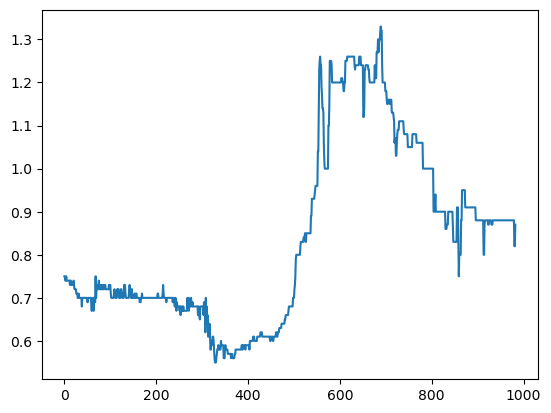

In [23]:
import matplotlib.pyplot as plt
plt.plot(df2)

In [24]:
import numpy as np


LSTM is very sensitive to scale so we have to use a min max scaler to process the data

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(np.array(df2).reshape(-1,1))

In [26]:
print(df2)

[[0.25641026]
 [0.25641026]
 [0.24358974]
 [0.24358974]
 [0.25641026]
 [0.24358974]
 [0.24358974]
 [0.24358974]
 [0.24358974]
 [0.24358974]
 [0.24358974]
 [0.24358974]
 [0.23076923]
 [0.24358974]
 [0.24358974]
 [0.23076923]
 [0.23076923]
 [0.23076923]
 [0.23076923]
 [0.23076923]
 [0.24358974]
 [0.23076923]
 [0.21794872]
 [0.21794872]
 [0.21794872]
 [0.21794872]
 [0.20512821]
 [0.20512821]
 [0.20512821]
 [0.19230769]
 [0.19230769]
 [0.20512821]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.16666667]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.17948718]
 [0.17948718]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.19230769]
 [0.15384615]
 [0.15384615]
 [0.16666667]
 [0.19230769]
 [0.19230769]
 [0.15384615]
 [0.19230769]
 [0.19230769]
 [0.17948718]
 [0.25641026]
 [0.19230769]
 [0.21794872]
 [0.21

In [27]:
#splitting data set into training and test data
#training data = 70% of data set
#test data =  30%
training_size = int(len(df2)*0.7)
test_size = len(df2)-training_size
train_data, test_data = df2[0:training_size,:],df2[training_size:len(df2),:1]

In [28]:
#checking the sizes
training_size,test_size

(688, 295)

In [29]:
import numpy
#method to convert array of vals into dataset matrix
def create_dataset(data, time_step=1):
    dataX, dataY = [],[]
    for i in range(len(data)-time_step-1):
        out = data[i:(i+time_step),0]
        dataX.append(out)
        dataY.append(data[i + time_step,0])
    return numpy.array(dataX),numpy.array(dataY)

In [30]:
time_step=100
x_train, y_train = create_dataset(train_data,time_step)
x_test,y_test=create_dataset(test_data,time_step)

Two cells below are for checking the number of features

In [31]:
print(x_train.shape),print(y_train.shape)
#left is number of records, right is number of time steps

(587, 100)
(587,)


(None, None)

In [32]:
print(x_test.shape),print(y_test.shape)

(194, 100)
(194,)


(None, None)

In [33]:
#reshape input to be [samples, time steps, features] for LSTM
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [34]:
###creating the LSTM model
#import sequential from tensorflow.keras.models
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [35]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

Printing out a summary

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1) # type: ignore

Epoch 1/100
10/10 [==============================] - 24s 924ms/step - loss: 0.0758 - val_loss: 0.0174
Epoch 2/100
10/10 [==============================] - 5s 532ms/step - loss: 0.0112 - val_loss: 0.0051
Epoch 3/100
10/10 [==============================] - 6s 652ms/step - loss: 0.0053 - val_loss: 0.0025
Epoch 4/100
10/10 [==============================] - 7s 708ms/step - loss: 0.0044 - val_loss: 0.0103
Epoch 5/100
10/10 [==============================] - 10s 1s/step - loss: 0.0039 - val_loss: 0.0048
Epoch 6/100
10/10 [==============================] - 7s 708ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 7/100
10/10 [==============================] - 10s 886ms/step - loss: 0.0034 - val_loss: 0.0083
Epoch 8/100
10/10 [==============================] - 7s 743ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 9/100
10/10 [==============================] - 7s 713ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 10/100
10/10 [==============================] - 6s 639ms/step - loss: 0.0031 - val_lo

In [38]:
import tensorflow as tf